In [1]:
# from Pipeline import WifiPipeline
from MulticlassDCP import WifiMulticlassDCP

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler

# System libraries
import itertools
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create, process dataframe

In [2]:
start_time = time.time()

In [3]:
w = WifiMulticlassDCP()

In [4]:
df = w.make_dataframe()

# Take out packets from router
df = df[df["DeviceType"]!="router"]
print len(df)

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64
158142


# Prep dataset

In [5]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["bulb", "camera", "plug"]

In [6]:
# Prep training set
df_train = df[df['Set']=='train']
print df_train['DeviceType'].value_counts()

plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64


Initial test set distribution:
camera    20117
plug       1870
bulb        545
Name: DeviceType, dtype: int64


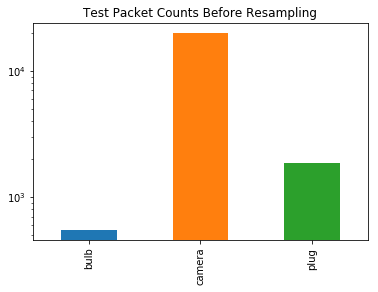

In [7]:
df_test = df[df['Set']=='test']

# Show initial test set imbalance
print "Initial test set distribution:"
print df_test['DeviceType'].value_counts()
df_test['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Before Resampling",logy=True);

In [8]:
# Downsample test set so that there is equal chance that the classifier will choose any given class
rds = RandomUnderSampler(random_state=42)
test_X_downsampled, test_y_downsampled = rds.fit_resample(df_test[features_list], df_test['DeviceType'])

# Show class counts after downsampling
unique, counts = np.unique(test_y_downsampled, return_counts=True)
print np.asarray((unique, counts)).T

[['bulb' 545]
 ['camera' 545]
 ['plug' 545]]


In [9]:
# Recreate df_test 
df_test_downsampled = pd.DataFrame(test_X_downsampled,columns=features_list)
df_test_downsampled['DeviceType'] = test_y_downsampled

# Run multiclass

In [10]:
multiclass_start = time.time()

preds, metrics, cms, feature_importance = w.run_multiclass(df_train, df_test_downsampled, features_list, y_list)

multiclass_end = time.time() - multiclass_start

# Report results

## Report confusion matrices

Confusion matrix, without normalization
[[537   4   4]
 [  0 342 203]
 [  3 102 440]]
Confusion matrix, without normalization
[[545   0   0]
 [  0 194 351]
 [  0 130 415]]
Confusion matrix, without normalization
[[545   0   0]
 [166  46 333]
 [103  15 427]]


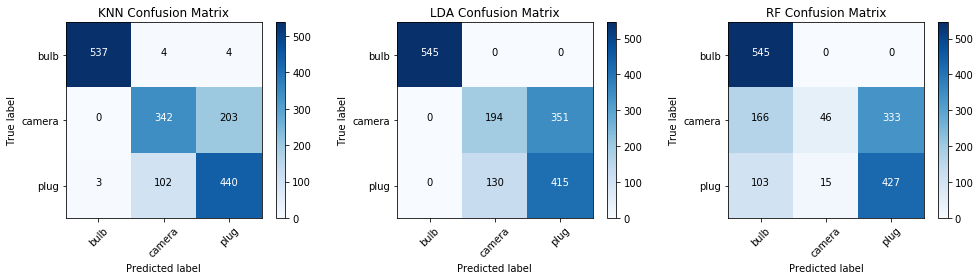

In [11]:
w.plot_all_confusion_matrices(cms, y_list)

## Report metrics

In [12]:
metrics_df = w.report_metrics(metrics, y_list, 'wifi-multiclass_metrics')
display(metrics_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Bulb,Precision_Camera,Precision_Plug,Recall_Bulb,Recall_Camera,Recall_Plug
KNN,0.714077,0.812633,0.806728,0.994444,0.763393,0.680062,0.985321,0.627523,0.807339
RF,0.484556,0.661825,0.622630,0.669533,0.754098,0.561842,1.000000,0.084404,0.783486
LDA,0.574687,0.713514,0.705810,1.000000,0.598765,0.541775,1.000000,0.355963,0.761468


## Report feature importance

In [13]:
f_i = w.report_featureimportance(feature_importance, features_list)
display(f_i)

Dropcam         0.44468
Belkin          0.35529
Assoc_Packets   0.10416
PacketLength    0.06063
QoS_Null        0.02477
QoS_Data        0.00750
Data            0.00216
Lifi            0.00081
Tp-link         0.00001
Netgear         0.00000
dtype: float64

# Residuals Analysis

## Use only top 3 features

### Run multiclass with top 3 features

In [20]:
# Run multiclass with top 3 features
tf3_preds, tf3_metrics, tf3_cms, tf3_feature_importance = w.run_multiclass(df_train, df_test_downsampled, list(f_i.index[0:3]), y_list,use_tuned=False)

In [21]:
tf3_metrics_df = w.report_metrics(tf3_metrics, y_list, 'wifi-tf3_metrics')
display(tf3_metrics_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Bulb,Precision_Camera,Precision_Plug,Recall_Bulb,Recall_Camera,Recall_Plug
KNN,0.32594,0.42824,0.52599,0.42585,0.00787,0.85098,0.77982,0.00183,0.79633
RF,0.49356,0.48431,0.59939,0.48748,0.11111,0.85433,1.00000,0.00183,0.79633
LDA,0.55964,0.78709,0.67768,0.99492,0.50976,0.85659,0.35963,0.86239,0.81101


### Plot confusion matrices

Confusion matrix, without normalization
[[425 118   2]
 [470   1  74]
 [103   8 434]]
Confusion matrix, without normalization
[[196 349   0]
 [  1 470  74]
 [  0 103 442]]
Confusion matrix, without normalization
[[545   0   0]
 [470   1  74]
 [103   8 434]]


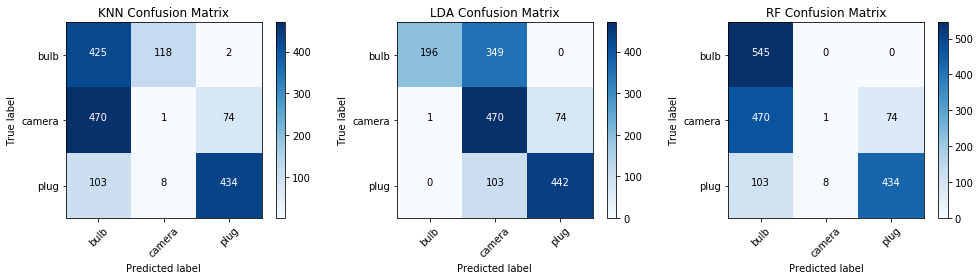

In [22]:
w.plot_all_confusion_matrices(tf3_cms, y_list)

### Report feature importance of 3 best

In [23]:
w.report_featureimportance(tf3_feature_importance, f_i.index[0:3])

Dropcam         0.49464
Belkin          0.30415
Assoc_Packets   0.20122
dtype: float64

## Remove vendor features

In [24]:
# Remove vendors features
nv_features = ['PacketLength', 'Tp-link', 'Data', 'QoS_Data', 'QoS_Null', 'Assoc_Packets']

In [25]:
nv_start = time.time()

# Run multiclass with top k features
nv_preds, nv_metrics, nv_cms, nv_feature_importance = w.run_multiclass(df_train, df_test_downsampled, nv_features, y_list,use_tuned=False)

nv_end = time.time() - nv_start

In [26]:
nv_metrics_df = w.report_metrics(nv_metrics, y_list, 'wifi-novendor_metrics')
display(nv_metrics_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Bulb,Precision_Camera,Precision_Plug,Recall_Bulb,Recall_Camera,Recall_Plug
KNN,0.68661,0.79706,0.78899,0.99413,0.71698,0.68006,0.93211,0.62752,0.80734
RF,0.42227,0.54130,0.59572,0.91257,0.22886,0.48249,0.91927,0.08440,0.78349
LDA,-0.09269,0.27691,0.27156,0.00000,0.05503,0.77570,0.00000,0.05321,0.76147


Confusion matrix, without normalization
[[508  33   4]
 [  0 342 203]
 [  3 102 440]]
Confusion matrix, without normalization
[[  0 471  74]
 [470  29  46]
 [103  27 415]]
Confusion matrix, without normalization
[[501  40   4]
 [ 45  46 454]
 [  3 115 427]]


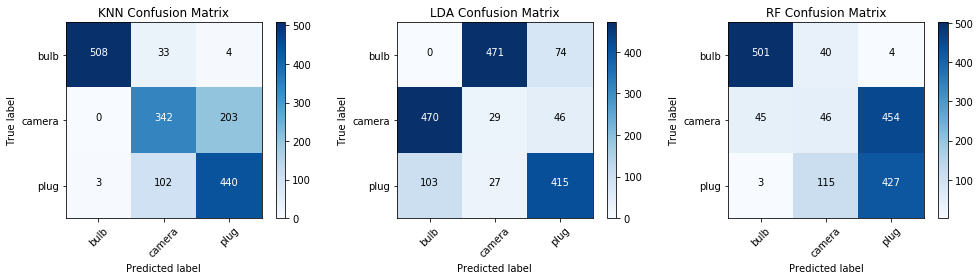

In [27]:
w.plot_all_confusion_matrices(nv_cms, y_list)

In [28]:
w.report_featureimportance(nv_feature_importance, nv_features)

Assoc_Packets   0.92621
PacketLength    0.03283
Data            0.02683
QoS_Data        0.00786
QoS_Null        0.00505
Tp-link         0.00123
dtype: float64

## Error analysis

In [29]:
def output_decisionpath(model, features_list, class_names, filename):
    # Source: https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

    # Extract single tree
    estimator = model.estimators_[5]

    from sklearn.tree import export_graphviz
    # Export as dot file
    export_graphviz(estimator, out_file='tree.dot', 
                    feature_names = features_list,
                    class_names = class_names,
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    call(['dot', '-Tpng', 'tree.dot', '-o', 'Results/'+filename+'.png', '-Gdpi=600'])

**Error 1**: KNN and RF confuse camera and plugs

In [30]:
# Get camera and plug packets
df_train_camplugs = df_train[(df_train['DeviceType']=='camera') | (df_train['DeviceType']=='plug')]

df_test_camplugs = df_test_downsampled[(df_test_downsampled['DeviceType']=='camera') | (df_test_downsampled['DeviceType']=='plug')]

Isolate the two classes

In [31]:
# Run multiclass on just the two device types
camplugs_preds, camplugs_metrics, camplugs_cms, camplugs_feature_importance = w.run_multiclass(df_train_camplugs, df_test_camplugs, features_list, ['camera','plug'],use_tuned=False)

In [32]:
camplugs_metrics_df = w.report_metrics(camplugs_metrics, ['camera','plug'], 'wifi-camplugs_metrics')
display(camplugs_metrics_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Camera,Precision_Plug,Recall_Camera,Recall_Plug
KNN,-0.07908,0.45131,0.46789,0.42291,0.47972,0.17615,0.75963
RF,0.72158,0.86474,0.85688,0.81120,0.91828,0.93028,0.78349
LDA,0.12847,0.57027,0.55872,0.59877,0.54178,0.35596,0.76147


Confusion matrix, without normalization
[[ 96 449]
 [131 414]]
Confusion matrix, without normalization
[[194 351]
 [130 415]]
Confusion matrix, without normalization
[[507  38]
 [118 427]]


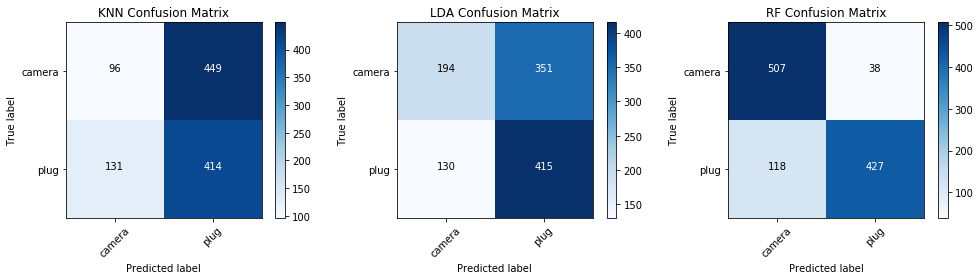

In [33]:
w.plot_all_confusion_matrices(camplugs_cms, ['camera','plug'])

In [34]:
w.report_featureimportance(camplugs_feature_importance, features_list)

Belkin          0.45660
Assoc_Packets   0.27941
Dropcam         0.18489
PacketLength    0.03493
Data            0.01714
QoS_Data        0.01518
QoS_Null        0.01184
Tp-link         0.00000
Netgear         0.00000
Lifi            0.00000
dtype: float64

Show features

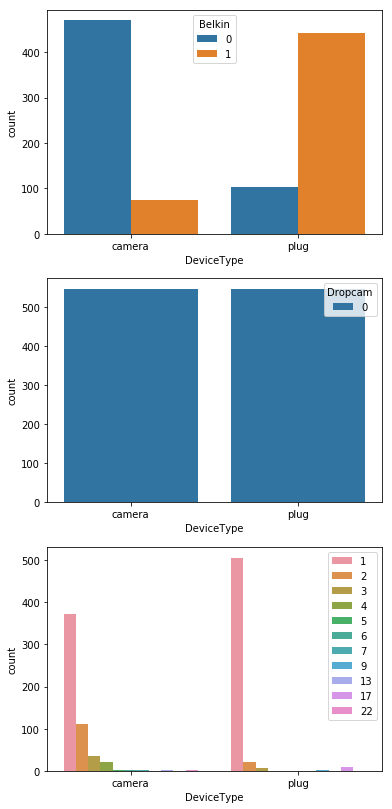

In [35]:
f, axes = plt.subplots(3, 1, figsize=(6, 14))
sns.countplot(x='DeviceType', hue='Belkin',ax=axes[0], data=df_test_camplugs);
sns.countplot(x='DeviceType', hue='Dropcam',ax=axes[1], data=df_test_camplugs);
sns.countplot(x='DeviceType', hue='Assoc_Packets',ax=axes[2], data=df_test_camplugs);
plt.legend(loc='upper right');

Use only top 3 features for camera vs plugs classification

In [47]:
# Run multiclass on just the two device types
camplugs_preds_bf, camplugs_metrics_bf, camplugs_cms_bf, camplugs_feature_importance_bf= w.run_multiclass(df_train_camplugs, df_test_camplugs, ['Belkin','Dropcam','Assoc_Packets'], ['camera','plug'],use_tuned=False)

In [48]:
camplugs_metrics__bf_df = w.report_metrics(camplugs_metrics_bf, ['camera','plug'], 'wifi-camplugs_bestfeatures_metrics')
display(camplugs_metrics__bf_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Camera,Precision_Plug,Recall_Camera,Recall_Plug
KNN,0.45768,0.73110,0.72661,0.76333,0.69887,0.65688,0.79633
RF,0.66208,0.83180,0.83028,0.80928,0.85433,0.86422,0.79633
LDA,0.04589,0.61479,0.50459,0.72727,0.50232,0.01468,0.99450


Confusion matrix, without normalization
[[358 187]
 [111 434]]
Confusion matrix, without normalization
[[  8 537]
 [  3 542]]
Confusion matrix, without normalization
[[471  74]
 [111 434]]


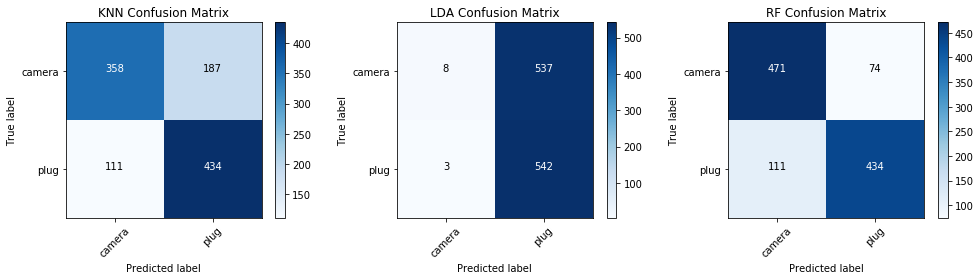

In [49]:
w.plot_all_confusion_matrices(camplugs_cms_bf, ['camera','plug'])

In [50]:
w.report_featureimportance(camplugs_feature_importance_bf, ['Belkin','Dropcam','Assoc_Packets'])

Belkin          0.50074
Assoc_Packets   0.29722
Dropcam         0.20204
dtype: float64

In [36]:
w_rf_camplug = RandomForestClassifier()
rf_camplug_model = w_rf_camplug.fit(df_train_camplugs[features_list], df_train_camplugs['DeviceType'])
dp = w_rf_camplug.decision_path(df_test_camplugs[features_list])

In [37]:
output_decisionpath(rf_camplug_model, features_list, ['camera','plug'], 'rf-camplug-tree')

In [46]:
print multiclass_end
print fs_end
print nv_end
print time.time() - start_time

73.6617748737
378.788547039
40.2277908325
940.127942085
